# Optimization for Robotics Summer School 2025

## 14-18 July, 2025, University of Patras, Greece

**Instructor:** Zac Manchester (zacm@cmu.edu)

<div>
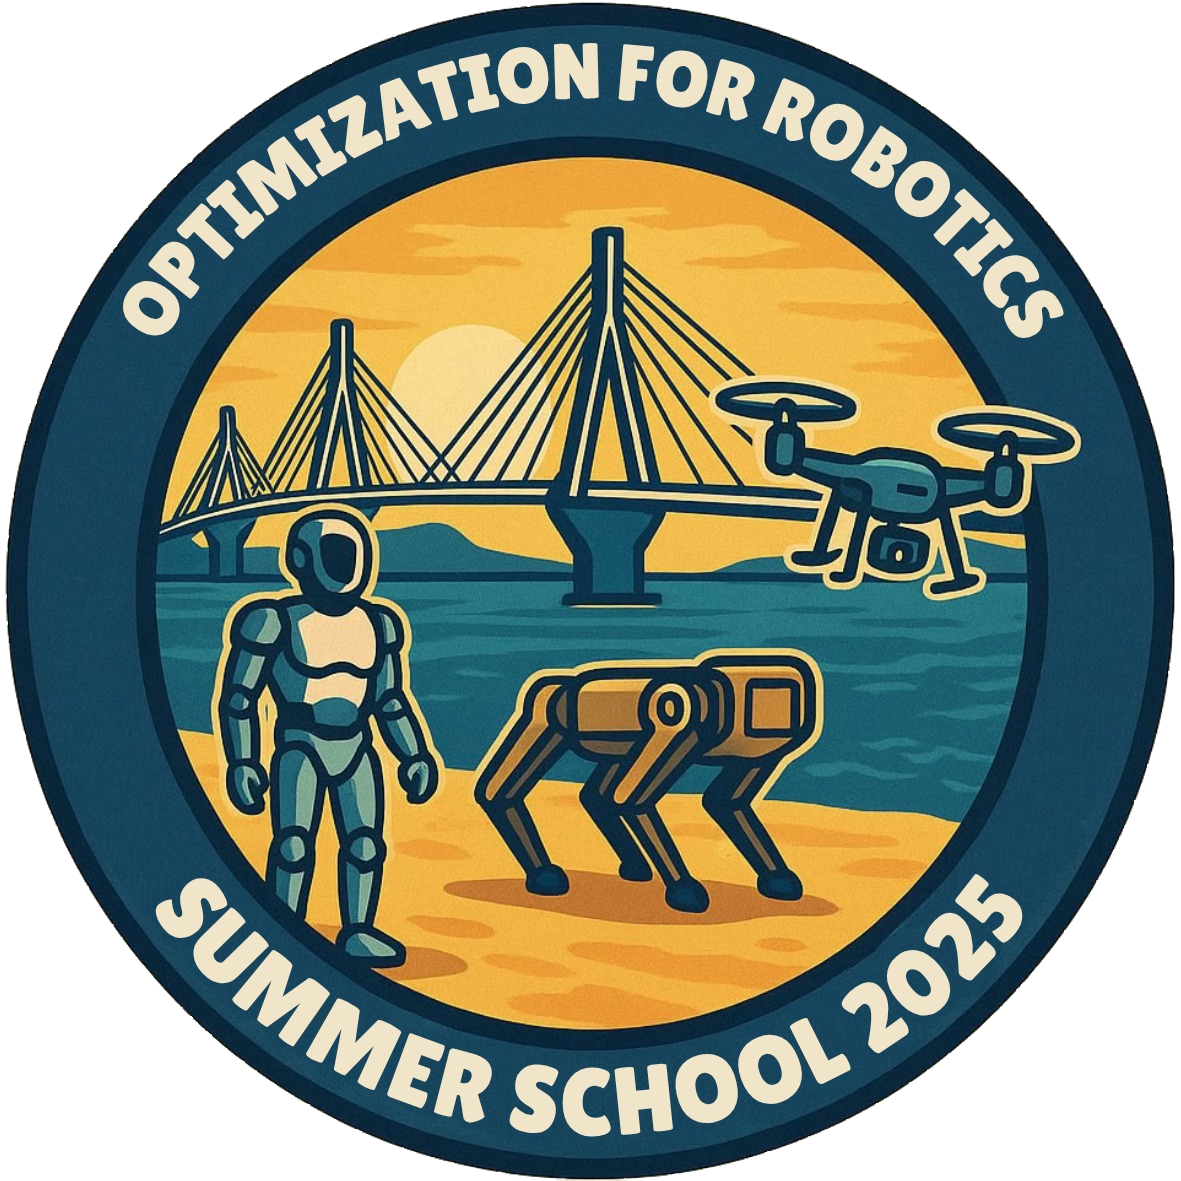
</div>

## Thursday Practicals - State Estimation

In [ ]:
# Imports
import numpy as np # Linear Algebra
import scipy # For matrix exponential
import matplotlib.pyplot as plt # Plotting

## Linear Least Squares

### First we'll look at a very simple linear system: a damped simple-harmonic oscillator

In [ ]:
# Dynamics
dt = 0.1
A_continuous = np.array([[0., 1.], [-1, -0.1]])
A = scipy.linalg.expm(dt*A_continuous)

In [ ]:
# Noise
W = np.eye(2) * 0.0001 #process noise in the dynamics
V = 0.3 #measurement noise

Winv = np.linalg.inv(W)
Vinv = 1/V

In [ ]:
# Simulate
Tfinal = 10
Nt = 101
xtraj = np.zeros((2, Nt))
xtraj[0,0] = 1.0

for k in range(Nt-1):
    xtraj[:,k+1] = A@xtraj[:,k] + np.random.multivariate_normal(np.zeros((2,)), W)

In [ ]:
times = np.linspace(0,Tfinal,Nt)
plt.plot(times, xtraj[0,:], label='q')
plt.plot(times, xtraj[1,:], label='v')
plt.legend()

In [ ]:
# Generate noisy measurements
y = xtraj[0,:] + np.random.normal(0, V, Nt)

In [ ]:
plt.plot(times, xtraj[0,:], label='q')
plt.plot(times, y, label='y')
plt.legend()

Define the measurement model such that $y = Cx$

In [ ]:
# Define the measurement model
C = #Fill me in

We want to minimize the sum of the squares of the measurement and dynamics residuals. Therefore, our objective function is:

$\min \frac{1}{2} \sum_k \frac{1}{2} (y_k - Cx_k)^T V^{-1} (y_k-Cx_k) + \frac{1}{2} (x_{k+1} - A x_k)^T W^{-1} (x_{k+1} - A x_k)$

This is an unconstrained QP. Write it in the standard form:

$\min \frac{1}{2} x^T H x - g^T x$

In [ ]:
# Standard QP matrices

H = #Fill me in
g = #Fill me in

In [ ]:
# Solve the qp to recover the estimate of the state trajectory

xest = np.reshape(np.linalg.solve(H,g), (2,Nt), order='F')

In [ ]:
# Plot the estimate vs. the ground truth
plt.plot(times, xtraj[0,:], label='qtrue')
plt.plot(times, xest[0,:], label='qest')
plt.legend()

In [ ]:
# Note that we recovered the velocities as well. Let's compare to finite-differences
vfd = np.diff(y)/dt
plt.plot(times, xtraj[1,:], label='vtrue')
plt.plot(times, xest[1,:], label='vest')
plt.plot(times[0:-1] + dt/2, vfd, label='vfd')
plt.legend()

## Kalman Filter

### Now we'll solve the same problem with a Kalman filter

In [ ]:
# Initialization
xfilt = np.zeros((2,Nt))
xfilt[:,0] = np.random.multivariate_normal(xtraj[:,0], W)

P = np.zeros((2,2,Nt))
P[:,:,0] = W

In [ ]:
for k in range(Nt-1):
    #Prediction
    xpred = #Fill me in
    Ppred = #Fill me in

    #Innovation
    z = #Fill me in
    S = #Fill me in

    #Kalman Gain
    L = #Fill me in

    #Update
    xfilt[:,k+1] = #Fill me in
    P[:,:,k+1] = #Fill me in

In [ ]:
# Plot the estimate vs. the ground truth
plt.plot(times, xtraj[0,:], label='qtrue')
plt.plot(times, xest[0,:], label='qest')
plt.plot(times, xfilt[0,:], label='qfilt')
plt.legend()

In [ ]:
plt.plot(times, xtraj[1,:], label='vtrue')
plt.plot(times, xest[1,:], label='vest')
plt.plot(times, xfilt[1,:], label='vfilt')
plt.legend()

### Do the filter results match the least-squares results?

## Nonlinear Lest Squares

### Now we'll look at everyone's favorite 2D nonlinear system: the pendulum

In [ ]:
# Dynamics
def pendulum_dynamics(x, u):
    gravity = 9.81
    length = 1.
    mass = 1.
    x_dot = np.concatenate([x[1:], -(gravity/length)*np.sin(x[:1]) + 1./(mass*length*length)*u], axis=0)
    return x_dot

def pendulum_step(x, u):
    dt = 0.1
    xm = x + pendulum_dynamics(x,u)*dt/2
    return x + pendulum_dynamics(xm,u)*dt

In [ ]:
# Dynamics Jacobians
def pendulum_deriv(x, u):
    gravity = 9.81
    length = 1.
    mass = 1.
    return np.array([[0., 1.], [-(gravity/length)*np.cos(x[0]), 0.]])

def pendulum_step_deriv(x, u):
    dt = 0.1
    xm = x + 0.5*dt*pendulum_dynamics(x,u)
    return np.eye(2) + dt*pendulum_deriv(xm,u)@(np.eye(2) + 0.5*dt*pendulum_deriv(x,u))

In [ ]:
# Measurements: we can see the tip of the pendulum
def tip(x):
    length = 1.
    px = length * np.sin(np.pi - x[0])
    py = length * np.cos(np.pi - x[0])

    return np.array([px, py])

def tip_deriv(x):
    length = 1.
    return np.array([[-length * np.cos(np.pi - x[0]), 0.], [length * np.sin(np.pi - x[0]), 0.]])

In [ ]:
# Noise
W = np.eye(2) * 0.0001 #process noise
V = np.eye(2) * 0.1 #measurement noise

In [ ]:
# Simulation
Tfinal = 10
Nt = 101
xtraj = np.zeros((2, Nt))
xtraj[:,0] = np.array([[2.5, 0]])

ytraj = np.zeros((2, Nt))
ytraj[:,0] = tip(xtraj[:,0])

for k in range(Nt-1):
    xtraj[:,k+1] = pendulum_step(xtraj[:,k], 0) + np.random.multivariate_normal(np.zeros((2,)), W)
    ytraj[:,k+1] = tip(xtraj[:,k+1]) + np.random.multivariate_normal(np.zeros((2,)), V)

In [ ]:
# Let's look at the state trajectory
times = np.linspace(0,Tfinal,Nt)
plt.plot(times, xtraj[0,:], label='q')
plt.plot(times, xtraj[1,:], label='v')
plt.legend()

In [ ]:
# Let's look at the measurements
plt.plot(times, ytraj[0,:])
plt.plot(times, ytraj[1,:])

In [ ]:
# Filter Initialization
xfilt = np.zeros((2,Nt))
xfilt[:,0] = xtraj[:,0] + np.random.multivariate_normal(np.zeros(2), W)

P = np.zeros((2,2,Nt))
P[:,:,0] = W

In [ ]:
for k in range(Nt-1):
    #Prediction
    xpred = #Fill me in
    A = #Fill me in
    Ppred = #Fill me in

    #Innovation
    z = #Fill me in
    C = #Fill me in
    S = #Fill me in

    #Kalman Gain
    L = #Fill me in

    #Update
    xfilt[:,k+1] = #Fill me in
    
    P[:,:,k+1] = #Fill me in

In [ ]:
# Plot the estimate vs. the ground truth
plt.plot(times, xtraj[0,:], label='qtrue')
plt.plot(times, xfilt[0,:], label='qfilt')
plt.legend()

In [ ]:
plt.plot(times, xtraj[1,:], label='vtrue')
plt.plot(times, xfilt[1,:], label='vfilt')
plt.legend()